#1 Introducción

En este ejercicio se muestra cómo procesar una imágen aumentando/disminuyendo su brillo o constrate. El algoritmo recorre pixel por pixel y utiliza OpenMP para optimizar el tiempo de procesamiento de la imágen. El algoritmo permite cargar una imagen desde una URL y específicar los valores de contraste y brillo


# 2. Armado del ambiente. 
Carga de imágen y preparación de entorno

In [ ]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://i.ibb.co/XtgzX2v/horse.jpg" #@param {type:"string"}

#IMAGEN EN 4K: https://i.ibb.co/XtgzX2v/horse.jpg

#@markdown ---
# Leo la imagen desde internet.
!wget {url_imagen} -O imagen.jpg

!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python


--2020-11-21 20:09:59--  https://i.ibb.co/XtgzX2v/horse.jpg
Resolving i.ibb.co (i.ibb.co)... 104.194.8.196, 172.96.140.18, 51.81.66.79, ...
Connecting to i.ibb.co (i.ibb.co)|104.194.8.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1951987 (1.9M) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]   1.86M  2.15MB/s    in 0.9s    

2020-11-21 20:10:01 (2.15 MB/s) - ‘imagen.jpg’ saved [1951987/1951987]

     |████████████████████████████████| 49.5MB 88kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


#3 Desarrollo

Codigo Python con C++ incrustado. Utilización de OpenMP y OpenCV para procesar las imágenes en C++

In [ ]:
code = """
// Hola Mundo desde OpenMP, usando c, ejecutado en Colab. 


#include <vector>
#include <omp.h>    // Cabecera OpenMP
#include <opencv2/core.hpp>
#include <opencv2/opencv.hpp>
#include <iostream>

using std::cin;
using std::cout;
using std::endl;
using namespace cv;

int main(int argc, char* argv[]) 
{
  
    std::cout<<"Inicio..."<<std::endl;

    // Verifico los parámetros de brillo y contraste
    if( argc != 3 )
    {
        std::cerr<< " Error en los parametros. Por faor indique: valor de contraste(flotante de 1.0 a 3.0), valor de brillo (entero de 0 a 100)."<<argc<<std::endl;
        exit( -1 );
    }


    //Test imagen

    Mat img = imread("imagen.jpg", IMREAD_UNCHANGED); // Leo la imagen que se guardó con python dentro de la instancia del servidor
    Mat imagen_editada = Mat::zeros( img.size(), img.type() ); // Nueva matriz con todos 0


    //Verifico la existencia de la iamgen
    if( img.empty() )
    {
      std::cerr<< " No se puedo encontrar la imagen."<<std::endl;
      return -1;
    }

    int rows = img.rows; // Filas de la imagen (largo)
    int cols = img.cols; // Columnas de la imagen (ancho)
    int channels = img.channels(); //Canales de la imagen

    std::cout << "Filas de la imagen = " << rows << std::endl;
    std::cout << "Columnas de la imagen = " << cols << std::endl;
    std::cout << "Canales de la imagen = " << channels << std::endl;


    double alpha = atof(argv[1]); /*< Simple contrast control  de 1.0 a 3.0*/
    int beta = atoi(argv[2]);;       /*< Simple brightness control de 0 a 100*/
    

    //Mido tiempos    
    time_t instanteInicial, instanteFinal;
    instanteInicial = time(0);


    // Comienzo region paralela
    #pragma omp parallel
    { 
        //Recorro las filas, columnas y canales de la imagen (compejidad O^3) con hilos administrados por openMP
        for( int y = 0; y < img.rows; y++ ) {
            for( int x = 0; x < img.cols; x++ ) {
                for( int c = 0; c < img.channels(); c++ ) {
                    imagen_editada.at<Vec3b>(y,x)[c] =
                      saturate_cast<uchar>( alpha*img.at<Vec3b>(y,x)[c] + beta ); // Modifica el contraste y el brillo de la foto
                }
            }
        }
    }
    // Fin region paralela

    instanteFinal = time(0);
    std::cout << "Tiempo empleado: " << instanteFinal - instanteInicial << " segundos" <<std::endl;


    imwrite("imagen_editada.jpg", imagen_editada); //Escribo la imagen en el servidor

    std::cout<<"Fin..."<<std::endl;
   
}



"""
text_file = open("code.cpp", "w")
text_file.write(code)
text_file.close()

#3.1 Compilación del código C++

Aquí se realiza la compilación del código C++ agregando las respectivas bibliotecas para poder utilizar OpenMP y OpenCV

In [ ]:
!g++ -o procesar_imagen -fopenmp code.cpp `pkg-config opencv --cflags --libs`

# 3.2 Ejecución del codigo C++

Acá se definen la cantidad de threads que se van a utilizar para procesar la imágen y ademas se ejecuta el codigo C++

Enviar como primer parámetro un valor de contraste (0.0 a 3.0)
Enviar como segundo parámetro un valor de brillo (0 a 100)

In [ ]:
%env OMP_NUM_THREADS=5
!./procesar_imagen 3 50

env: OMP_NUM_THREADS=5
Inicio...
Filas de la imagen = 2160
Columnas de la imagen = 3840
Canales de la imagen = 3
Tiempo empleado: 3 segundos
Fin...


#3.3 Visualización de resultados en Python

Aquí se visualizan los resultados de las dos imagenes (antes y después de procesar)

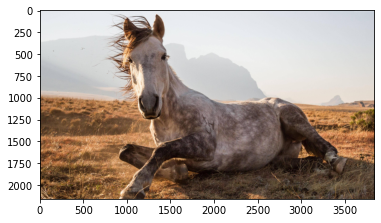

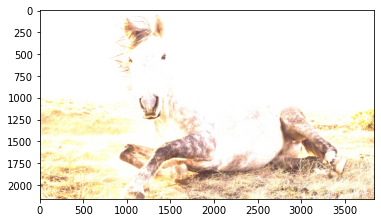

In [ ]:
%matplotlib inline

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

try:
  img_nombre = 'imagen.jpg'
  imagen = Image.open( img_nombre ) 

  img_editada_nombre = 'imagen_editada.jpg'
  imagen_editada = Image.open( img_editada_nombre ) 
    
    
  # Convierto las imagenes comprimida en JPEG/PNG a array.
  img_array = numpy.asarray(imagen)
  img_editada_array = numpy.asarray(imagen_editada)


  #Muestro la iamgen original
  plt.figure()
  imgplot = plt.imshow(img_array)

  # Muestro la imagen editada
  plt.figure()
  imgplot = plt.imshow(img_editada_array)
except FileNotFoundError as fileNotFound:
  print("Ups, no se encontró la imagen :(");
  print(fileNotFound)


---
#4. Tabla de pasos

 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param url_imagen                | Url de la imagen a procesar
CPU C++ | include | incluye las bibliotecas necesarias para el algoritmo
CPU-C++      |  std::cout                | Muestra un mensaje por consola
CPU C++     |  imread()                | Lee una imagen desde un archivo y la transforma a una matriz
CPU C++     |  Mat::zeros                | iniciliza una matriz con ceros
CPU C++      |  atoi        | transforma string en entero
CPU C++     | atof |  transforma string en double
CPU C++ | time(0) | toma el tiempo inicial
CPU C++ | #pragma omp parallel | iniciliza código en paralelo con hilos administrados por OpenMP
CPU C++ | for...for...for | procesamiento de imagen con modificacion de contraste y brillo
CPU C++ | imwrite() | Escribe la imagen procesada en un archivo en el serbidor
CPU python | open ("code.cpp", "w") | abre archivo en modo escritura
CPU python | write() | escribe el archivo en el servidor
CPU C++ | gcc ++ | compila el código C++ generado anteriormente.
CPU python |  %env OMP_NUM_THREADS | define la cantidad de threads
CPU | !./procesar_imagen 3 50 | ejecuta el codigo C++ que edita la imagen indicando como primer valor el constrate y segundo valor el brillo
CPU python | import | importa dependencias para mostrar las imagenes
CPU python | Image.open | Abre la imagen desde un archivo
CPU python | numpy.asarray | convierte la imagen en un array (matriz) 
CPU python | plt.imshow() | muestra la imagen por pantalla desde un array
CPU python | print() | imprime mensaje por pantalla

---
#5. Bibliografia

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] OpenCV con C++: [OpenCV con C++](https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html)

[5] OpenMP con c++: [OpenMP con C++](https://www.openmp.org/wp-content/uploads/OpenMP-4.0-C.pdf)

[6] Numpy AS ARRAY: [Numpy as array](https://numpy.org/doc/stable/reference/generated/numpy.asarray.html)

---
#6. Conclusión

En este ejercicio se demostró el conocimiento de Colab, Python, C++, procesamiento de imágenes y el aprovechamiento de HPC para determinados algoritmos. Si bien en este algoritmo no se nota una mejora considerable utiliznado threads de OpenMP, se demostró como poder utilizar las herramientas que ofrece Colab e integrarlas en un mismo bloc de notas que facilitando así la ejecución y el armado del ambiente.

Lecciones aprendidas: para procesar archivos que fueron leidos desde python se puede utilizar el propio servidor de colab para almacernalo y luego leerlo desde C++. Una vez trabajado el archivo, se escribe y se vuelve a leer desde Python.
Sugerencias del algoritmo: quizás se podría agregar algunas ediciones mas sobre la imágen como por ejemplo filtros o cambios de colores. Ademas de profundizar un poco en OpenCV ya que posee mucho potencial. Quizás también sería útil tratar algunas excepciones que pueden surgir en la ejecución. Se podría mejorar la precisión del tiempo que tarda el algoritmo (pasarlo a MS).